# Assignment 2
## Facial Point Detection

This assignment approaches the computer vision problem of detecting facial keypoints in an image using various deep learning techniques.

The training dataset consists of 7,049 96x96 gray-scale images. For each image, we're supposed learn to find the correct position (the ``x`` and ``y`` coordinates) of 15 keypoints, such as ``left_eye_center, right_eye_outer_corner, mouth_center_bottom_lip``, and so on. For some of the keypoints we only have about 2,000 labels, while other keypoints have more than 7,000 labels available for training.

Data can be downloaded from https://www.kaggle.com/c/facial-keypoints-detection/data

In the following lines we provide a simple solution: a neural net with a single hidden layer. This model can be used to provide a baseline result to be used for comparison.

The objectives of this assignment are:
+ To develop a better solution by extending the baseline model to convolutional neural nets.
+ To increase performance by using several tricks:
    + Data augmentation: flipped images, greylevel image editing, etc.
    + Changing learning rate and momentum over time.
    + Using regularization techniques such as Dropout or BatchNorm.
    + Instead of training a single model, train a few specialist networks, with each one predicting a different subset of target values (f.e. eye features, mouth features, etc.).
    + Etc.
    
For developing puposes it is not a bad idea to work with 43x43 images...
    
Advanced suggestions:
+ Use several loss functions (f.e. one computing the MSE of predicted points and another measuring a global deformation of the constellation of points).
+ Can we work in a lower dimensional space for representing points? This could help with hidden points, global deformations, etc.
    
At the end of the notebook you must report:
+ What is the best result you got when testing.
+ What architecture and tricks you used for that result.

The final model can be developed in Tensorflow or in Keras.

In [1]:
import os
import sys
from datetime import datetime
import numpy as np
import pandas as pd
from pandas import DataFrame
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

FTRAIN = 'data/training.csv'
FTEST = 'data/test.csv'
FLOOKUP = 'data/IdLookupTable.csv'

In [2]:
def load(test=False, cols=None, mirror=False):
    """Loads data from FTEST if *test* is True, otherwise from FTRAIN.
    Pass a list of *cols* if you're only interested in a subset of the
    target columns.
    """
    fname = FTEST if test else FTRAIN
    df = pd.read_csv(fname)
    
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))
    
    if cols:
        df = df[list(cols) + ['Image']]
                                    
    #print(df.count()) 
    df = df.dropna() 
    
    X = np.vstack(df['Image'].values) / 255. 
    X = X.astype(np.float32) 
    
    if not test: 
        y = df[df.columns[:-1]].values   
        if mirror:
            y[1::2] = 96 - 1 - y[1::2] # mirror target coordinates horizontally (i.e only change x coordinates)
        y = (y - 48) / 48 # scale target coordinates to [-1,1]
        X, y = shuffle(X, y, random_state=42) 
        y = y.astype(np.float32)
    else:
        y = None
        
    return X, y

def load2d(test=False, cols=None, mirror=False):
    X, y = load(test=test, cols=cols, mirror=mirror)
    X = X.reshape(-1, 96, 96, 1) 
    
    return X, y

# 1. Baseline

In [15]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD

model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(9216,)))
model.add(Dense(30)) 

sgd = SGD(lr=0.01, momentum=0.9, nesterov=True)
model.compile(loss='mean_squared_error', optimizer=sgd) 

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 100)               921700    
_________________________________________________________________
dense_6 (Dense)              (None, 30)                3030      
Total params: 924,730
Trainable params: 924,730
Non-trainable params: 0
_________________________________________________________________


In [16]:
X, y = load()

print("X.shape == {}; X.min == {:.3f}; X.max == {:.3f}".format(X.shape, X.min(), X.max()))
print("y.shape == {}; y.min == {:.3f}; y.max == {:.3f}".format(y.shape, y.min(), y.max()))

batch_size = 32
epochs = 100

history = model.fit(X, y,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.2 
                   )

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

Epoch 67/100
1712/1712 [==============================] - 1s 376us/step - loss: 0.0030 - val_loss: 0.0039
Epoch 68/100
1712/1712 [==============================] - 1s 389us/step - loss: 0.0029 - val_loss: 0.0038
Epoch 69/100
1712/1712 [==============================] - 1s 411us/step - loss: 0.0029 - val_loss: 0.0038
Epoch 70/100
1712/1712 [==============================] - 1s 365us/step - loss: 0.0029 - val_loss: 0.0039
Epoch 71/100
1712/1712 [==============================] - 1s 363us/step - loss: 0.0028 - val_loss: 0.0041
Epoch 72/100
1712/1712 [==============================] - 1s 387us/step - loss: 0.0028 - val_loss: 0.0038
Epoch 73/100
1712/1712 [==============================] - 1s 413us/step - loss: 0.0028 - val_loss: 0.0039
Epoch 74/100
1712/1712 [==============================] - 1s 488us/step - loss: 0.0027 - val_loss: 0.0038
Epoch 75/100
1712/1712 [==============================] - 1s 455us/step - loss: 0.0027 - val_loss: 0.0038
Epoch 76/100
1712/1712 [======================

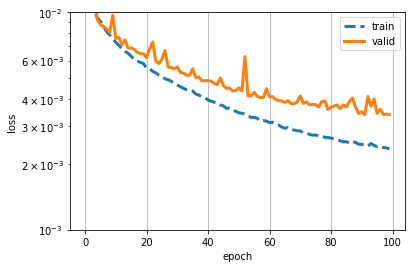

In [23]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(loss, linewidth=3, label='train', linestyle='--')
plt.plot(val_loss, linewidth=3, label='valid')
plt.grid()
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.ylim(1e-3, 1e-2)
plt.yscale('log') 
#plt.savefig()
plt.show()

In [ ]:
X_test, Y_test = load(test=True) 
y_pred = model.predict(X_test) 

In [45]:
def plot_sample(x, y, axis, y_label=None):
    img = x.reshape(96, 96) 
    axis.imshow(img, cmap='gray') 
    axis.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10)
    if not y_label is None:
        axis.scatter(y_label[0::2] * 48 + 48, y_label[1::2] * 48 + 48, marker='o', color='g', s=10)

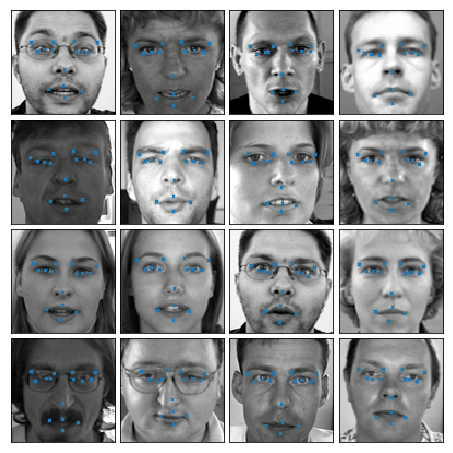

In [26]:
fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_sample(X_test[i], y_pred[i], ax)

#plt.savefig()
plt.show()

# 2. Using CNN

In [3]:
import numpy as np
from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.layers.core import Dense, Dropout, Flatten, Reshape, Activation
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

import matplotlib.pyplot as plt

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


#### Load data
The Training / Test / Validation split percentages are $70\%, 20\%, 10\%$ respectively. That results in 1498 training samples, 428 validation samples, and 214 test samples.

In [7]:
# load data
X, Y = load2d()

# split between train and validation
tr_size = int(0.7 * len(X))
vl_size = int(0.2 * len(X))
ts_size = int(0.1 * len(X))

X_train, X_val, X_test = X[:tr_size,:], X[tr_size:tr_size+vl_size,:], X[-ts_size:,:]
Y_train, Y_val, Y_test = Y[:tr_size,:], Y[tr_size:tr_size+vl_size,:], Y[-ts_size:,:]

print(X.shape)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(X.shape[0] == X_train.shape[0] + X_val.shape[0] + X_test.shape[0])

(2140, 96, 96, 1)
(1498, 96, 96, 1)
(428, 96, 96, 1)
(214, 96, 96, 1)
True


## Data augmentation
With this limited amount of data (1498 examples) the risk of overfitting the CNN is high. 
To counter this, I augment the training set using the following techniques:
- a) Mirroring (flip images horizontally)
- b) Add Gaussian white noise
- c) Add salt and pepper noise
- d) Change image contrast by Histogram Stretching

The transformations a), b), c), d) result in 4 further versions of the training data. These newly created datasets are then stacked together with the original training set, forming an augmented training set of $1498 \times 5 = 7490$ examples.

Since even this training set is relatively small, I further augment the training set "on the fly" (i.e. during training) 
adding a further Gaussian noise (with $\mu=0$ and $\sigma^2=0.01$). This kind of augmentation allows to have virtually infinite data.
Note that this time the noise is also added to the examples already obtained with a), b), c) or d).

The mirroring was not used at the end due to poor results.

#### Mirroring
Images and targets are flipped horizontally. This transformation is the most natural one.
It is needed to also change the column coordinates of the targets (the rows remain the same). This is achieved with the formula $y_{mirror} = N - 1 - Y_{original}$, where $N$ is the width of the image.

In [179]:
# flip images and targets
X_train_flipped = np.flip(X_train, axis=2) # flips images horizontally
Y_train_flipped = np.copy(Y_train)

Y_train_flipped = Y_train_flipped * 48 + 48                   # convert targets to original scale
Y_train_flipped[:, 0::2] = 96 - 1 - Y_train_flipped[:, 0::2]  # flip targets horizontally
Y_train_flipped = (Y_train_flipped - 48) / 48                 # convert targets to scale [-1, 1]

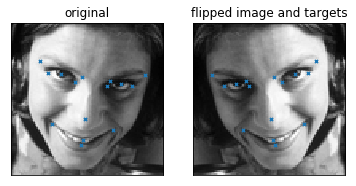

In [138]:
fig = plt.figure(figsize=(6, 6))
im_id = 1

# original image, original targets
ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
plt.title('original')
plot_sample(X_train[im_id], Y_train[im_id], ax)

# flipped image, flipped targets
ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
plt.title('flipped image and targets')
plot_sample(X_train_flipped[im_id], Y_train_flipped[im_id], ax)

#### Gaussian noise
To each training sample is added a Gaussian white noise  with $\mu = 0$ and $\sigma^2=0.05$.

In [8]:
gaussian_noise = np.random.normal(0, 0.05, X_train.shape)
X_train_noisy = np.copy(X_train) + gaussian_noise

print(X_train_noisy.shape)

(1498, 96, 96, 1)


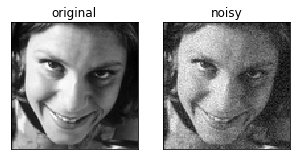

In [210]:
fig = plt.figure(figsize=(5, 5))

# original image
ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
plt.title('original')
ax.imshow(X_train[1].reshape(96,96), cmap='gray')

# noisy image
ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
plt.title('noisy')
ax.imshow(X_train_noisy[1].reshape(96,96), cmap='gray')

#### Salt and Pepper
Salt and pepper noise is added to $1\%$ of the pixels.

In [9]:
def salt_pepper_noise(x, salt_frac=0.01, pepper_frac=0.01):
    im_size = x.shape[1] * x.shape[1]
    n_salt = int(im_size *  salt_frac)
    n_pepper = int(im_size * pepper_frac)

    output = np.copy(x)
    salt_index_x = np.random.randint(low=0, high=96, size=n_salt)
    salt_index_y = np.random.randint(low=0, high=96, size=n_salt)
    
    pepper_index_x = np.random.randint(low=0, high=96, size=n_pepper)
    pepper_index_y = np.random.randint(low=0, high=96, size=n_pepper)
    
    output[:, salt_index_x, salt_index_y] = 1
    output[:, pepper_index_x, pepper_index_y] = 0
    
    return output


X_train_salt_pepper = salt_pepper_noise(X_train, 0.01, 0.01)

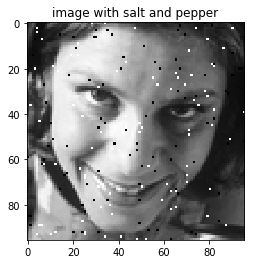

In [209]:
plt.title('image with salt and pepper')
plt.imshow(X_train_salt_pepper[1].reshape(96,96), cmap='gray')

#### Histogram stretching
Histogram stretching was used as a data augmentation technique to create an additional dataset with enanched contrast.
This is achieved by rescaling the image pixel intensities in the range $[a, b]$. To avoid the disruptive contribution of outliers, $a$ and $b$ were chosen as the $5^{th}$ and $95^{th}$ percentiles of the original image histogram. [Wang et Al., Facial Keypoints Detection](https://pdfs.semanticscholar.org/f9a3/072ee0a579475f5b5359e782ea32c2cbf24c.pdf)

In [12]:
#!pip install --upgrade pip
#!pip install scikit-image
import skimage
from skimage import exposure

# Contrast stretching
p5, p95 = np.percentile(X_train, (5, 95))
X_train_scaled = exposure.rescale_intensity(X_train, in_range=(p5, p95))

print('5th and 95th percentiles of the dataset are: %d, %d' %(p5 * 255, p95 * 255))

5th and 95th percentiles of the dataset are: 25, 226


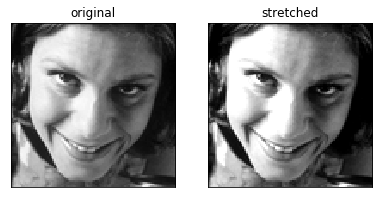

In [212]:
fig = plt.figure(figsize=(10, 10))

# original image
ax = fig.add_subplot(1, 3, 1, xticks=[], yticks=[])
plt.title('original')
ax.imshow(X_train[1].reshape(96,96), cmap='gray')

# image with rescaled intensities
ax = fig.add_subplot(1, 3, 2, xticks=[], yticks=[])
plt.title('stretched')
ax.imshow(X_train_scaled[1].reshape(96,96), cmap='gray')

In [13]:
# stack training sets 

#X_train = np.vstack((X_train, X_train_scaled))
#X_train = np.vstack((X_train, X_train_noisy))
#X_train = np.vstack((X_train, X_train_salt_pepper))
#X_train = np.vstack((X_train, X_train_flipped))
#Y_train = np.vstack((Y_train, Y_train_flipped))
#X_train = np.vstack((X_train, X_train_flipped, X_train_scaled, X_train_noisy, X_train_salt_pepper))
#Y_train = np.vstack((Y_train, Y_train_flipped, Y_train, Y_train, Y_train))

# DO NOT USE FLIPPED IMAGES
X_train = np.vstack((X_train, X_train_scaled, X_train_noisy, X_train_salt_pepper))
Y_train = np.vstack((Y_train, Y_train, Y_train, Y_train))

print (X_train.shape, Y_train.shape)

(5992, 96, 96, 1) (5992, 30)


## Metrics
I also report the Root Mean Squared Error in the original scale, which is the evaluation metric for the competition.

In [15]:
# additional metrics
from keras import backend
 
def rmse(y_true, y_pred):
    """
    Computes Root Mean Squared Error in the original scale
    """
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1)) * 48

metrics = [rmse]

## Model definition
- ReLU is used to speedup training and avoid the vanishing gradient problem
- MaxPooling2D with size 2 and stride 2 is used to halve the number of activations of the convolutional layers
- Dropout is used as regularization technique to avoid overfitting. The dropout fraction is $0.1$ for the convolutional layers and $0.5$ for the fully connected layers.
- The size of the convolutional kernels are $3 \times 3$ in the first two conv layers and $2 \times 2$ in the last two conv layers.
- The number of channels (i.e. filters) in the conv layers increases by a power of two from $16$ to $128$
- The network weights are initialized using Xavier initializer, which determines the weight scale based on input/output dimensions. The biases are initialized to zeros. (default setting)
- It is minimized the MSE using the Adam optimizer. The parameters of Adam are the default (i.e. $\alpha = 0.001$, $\beta_1 = 0.9$, and $\beta_2 = 0.999$). In addition I specify a learning rate decay of $10^{-6}$ at each epoch, to allow the optimization to settle into the minimum of the loss landscape.
- The MRSE is also reported in the original scale.

In [31]:
nb_filters = 16
nb_pool = 2
nb_conv = 3
nb_output = 30

model = Sequential()

# conv 1
model.add(Conv2D(nb_filters, (nb_conv, nb_conv), activation='relu', input_shape=X_train.shape[1:]))
model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
model.add(Dropout(0.1))

# conv 2
model.add(Conv2D(nb_filters*2, (nb_conv, nb_conv), activation='relu'))
model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
model.add(Dropout(0.1))

# conv 3
model.add(Conv2D(nb_filters*4, (nb_conv-1, nb_conv-1), activation='relu'))
model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
model.add(Dropout(0.1))

# conv 4
model.add(Conv2D(nb_filters*8, (nb_conv-1, nb_conv-1), activation='relu'))
model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
model.add(Dropout(0.1))

model.add(Flatten())
# dense 1
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))

# dense 2
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

# dense 3 - output
model.add(Dense(30))

optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=10e-6, amsgrad=False)
model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=metrics)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 94, 94, 16)        160       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 47, 47, 16)        0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 47, 47, 16)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 45, 45, 32)        4640      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 22, 22, 32)        0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 21, 21, 64)        8256      
__________

## Callbacks
Two callbacks are used after each epoch of training:
- EarlyStopping, to stop the training if the validation loss did not improve in the last 30 epochs. [Naimish et Al. Facial Key Points Detection using Deep Convolutional Neural Network - NaimishNet](https://arxiv.org/pdf/1710.00977.pdf)
- ModelCheckpoint, to save the best performing model in the validation set

In [33]:
# callback to stop training when the validation loss does not improve for 50 epochs
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=30, verbose=0, mode='auto')

# callback to save best performing model on validation set
filepath = 'final_model.{epoch:02d}-{val_loss:.5f}.hdf5'
model_checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False)

#### Train the model

In [34]:
batch_size = 32
epochs = 100

def add_gaussian_noise(img, mean=0, std=0.01):
    gaussian_noise = np.random.normal(mean, std, img.shape)
    return img + gaussian_noise

train_generator = ImageDataGenerator(preprocessing_function=add_gaussian_noise)
train_generator.fit(X_train)

# fits the model on batches with real-time data augmentation:
history = model.fit_generator(train_generator.flow(X_train, Y_train, batch_size=batch_size), 
                    steps_per_epoch=len(X_train) / batch_size,
                    epochs=epochs,
                    callbacks=[early_stopping, model_checkpoint],
                    validation_data=(X_val, Y_val),
                    use_multiprocessing=True)

Epoch 1/100
188/187 [==============================] - 48s 258ms/step - loss: 0.0121 - rmse: 4.7614 - val_loss: 0.0043 - val_rmse: 2.9687
Epoch 2/100
188/187 [==============================] - 49s 258ms/step - loss: 0.0059 - rmse: 3.4854 - val_loss: 0.0040 - val_rmse: 2.8317
Epoch 3/100
188/187 [==============================] - 52s 275ms/step - loss: 0.0052 - rmse: 3.2371 - val_loss: 0.0038 - val_rmse: 2.7496
Epoch 4/100
188/187 [==============================] - 48s 254ms/step - loss: 0.0046 - rmse: 3.0378 - val_loss: 0.0031 - val_rmse: 2.5144
Epoch 5/100
188/187 [==============================] - 51s 270ms/step - loss: 0.0040 - rmse: 2.8337 - val_loss: 0.0026 - val_rmse: 2.3023
Epoch 6/100
188/187 [==============================] - 48s 255ms/step - loss: 0.0035 - rmse: 2.6666 - val_loss: 0.0023 - val_rmse: 2.1383
Epoch 7/100
188/187 [==============================] - 48s 256ms/step - loss: 0.0032 - rmse: 2.5274 - val_loss: 0.0021 - val_rmse: 2.0601
Epoch 8/100
188/187 [=============

Epoch 60/100
188/187 [==============================] - 49s 261ms/step - loss: 9.6999e-04 - rmse: 1.4163 - val_loss: 0.0010 - val_rmse: 1.4015
Epoch 61/100
188/187 [==============================] - 52s 278ms/step - loss: 9.5644e-04 - rmse: 1.4075 - val_loss: 0.0010 - val_rmse: 1.3846
Epoch 62/100
188/187 [==============================] - 49s 261ms/step - loss: 9.6773e-04 - rmse: 1.4127 - val_loss: 0.0011 - val_rmse: 1.4268
Epoch 63/100
188/187 [==============================] - 49s 262ms/step - loss: 9.5789e-04 - rmse: 1.4030 - val_loss: 0.0011 - val_rmse: 1.4259
Epoch 64/100
188/187 [==============================] - 50s 267ms/step - loss: 9.4561e-04 - rmse: 1.3978 - val_loss: 0.0011 - val_rmse: 1.4009
Epoch 65/100
188/187 [==============================] - 50s 265ms/step - loss: 9.3195e-04 - rmse: 1.3887 - val_loss: 0.0010 - val_rmse: 1.3958
Epoch 66/100
188/187 [==============================] - 50s 263ms/step - loss: 9.4115e-04 - rmse: 1.3968 - val_loss: 0.0011 - val_rmse: 1.4171

In [35]:
# evaluate on test set
print(X_train.shape)
model.evaluate(X_test, Y_test)

(5992, 96, 96, 1)
214/214 [==============================] - 1s 2ms/step


[0.0012573644325189362, 1.5077891160394543]

#### plot learning curve
The best loss on the validation set was achieved at epoch $96$. That was discarded because overfitting occured after about 40 epochs, as the training loss keept decreasing while the validation loss increased. The model weights are selected after 44 epochs.

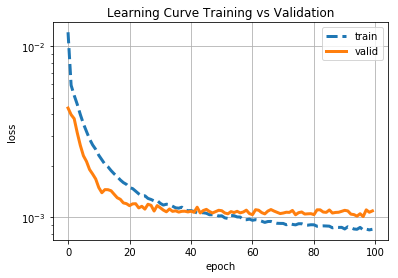

Validation loss at epoch 44: 0.00109
Validation loss at epochs 96: 0.00101. Overfitting!


In [41]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(loss, linewidth=3, label='train', linestyle='--')
plt.plot(val_loss, linewidth=3, label='valid')
plt.grid()
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
#plt.ylim(1e-3, 1e-2)
plt.yscale('log') 
#plt.savefig()
plt.title('Learning Curve Training vs Validation')
plt.show()

print("Validation loss at epoch 44: %.5f" % val_loss[44])
print("Validation loss at epochs %d: %.5f. Overfitting!" %(np.argmin(val_loss), val_loss[np.argmin(val_loss)]))

## Results on test set
I restore the model weights obtained after $44$ epochs of training. The evaluation of the model on the test set resulted in $0.001214$ normalized MSE and $1.50$ RMSE in the original scale.

In [42]:
model.load_weights('final_model.44-0.00106.hdf5')

In [43]:
y_pred = model.predict(X_test)
results = model.evaluate(X_test, Y_test)
print ("Test MSE (normalized): %.6f\nTest RMSE (original scale): %.2f" % (results[0], results[1]))

214/214 [==============================] - 0s 2ms/step
Test MSE (normalized): 0.001214
Test RMSE (original scale): 1.50


#### Visualize results
Plot test images along with predictions (in blue) and ground truth (in green)

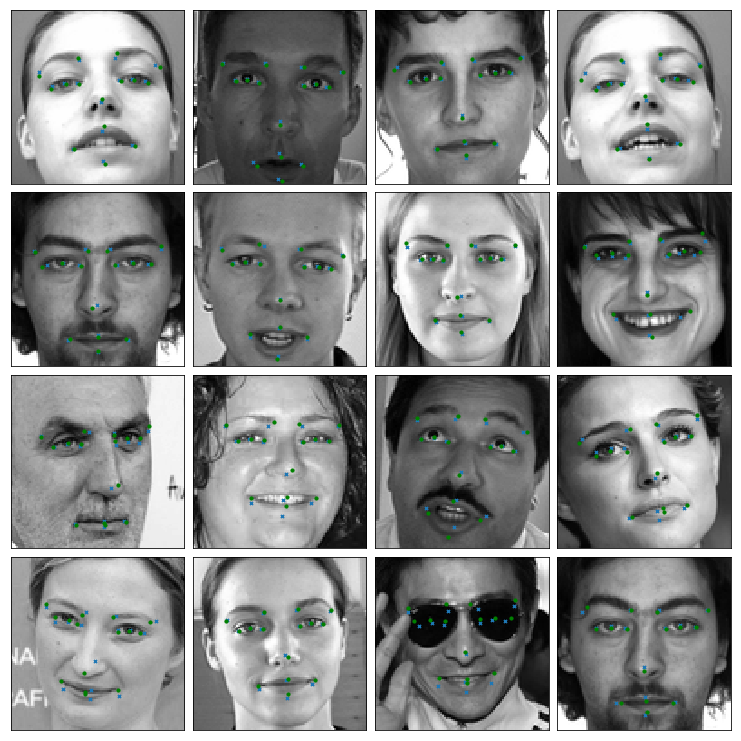

In [46]:
fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_sample(X_test[i], y_pred[i], ax, Y_test[i])

plt.show()

# Discussion
Here are some considerations after 20 epochs of training.

**On the augmentation...**

To better highlight the contribution of different augmentation techiniques, the CNN was trained for 20 epochs, and the performance was evaluated on both training and validation set. 


- original (not augmented) training set $\rightarrow$ tr_loss: $0.0054$ - val_loss: $0.0038$

---------------------------------------

Separate contributions:

- \* original $+$ flipped                  $\rightarrow$ tr_loss: $0.0396$ - val_loss: $0.0359$ $\rightarrow$ unstable learning curve (only on validation set)
- original $+$ noise                    $\rightarrow$ tr_loss: $0.0031$ - val_loss: $0.0021$
- original $+$ salt&pepper              $\rightarrow$ tr_loss: $0.0035$ - val_loss: $0.0024$
- original $+$ histogram                $\rightarrow$ tr_loss: $0.0030$ - val_loss: $0.0020$
-----------------------------------------------------------------------------
Combined augmentations:

- all togheter (no flip)                $\rightarrow$ tr_loss: $0.0022$ - val_loss: $0.0015$
- all together                          $\rightarrow$ tr_loss: $0.0147$ - val_loss: $0.0217$ $\rightarrow$ unstable learning curve (only validation curve)

With augmentation on the fly:

- all (no flip) $+$ online augmentation $\rightarrow$ tr_loss: $0.0020$ - val_loss: $0.0015$
- all $+$ online augmentation           $\rightarrow$ tr_loss: $0.0142$ - val_loss: $0.0208$ $\rightarrow$ unstable learning curve (only validation)

We can see that each individual augmentation helps reduce the training and validation error, with respect to the performance obtained on the original training set. The only exceptions is the mirroring (*), which obtained worse results and a much more unstable learning curve.
Combining all the augmentation, and also adding the on-the-fly augmentation, yelded even better results. However using mirroring the performance dropped and learning became instable. For this reason it was not used in the final model.

**On regularization**
It was tried to use batch normalization layers to feed each layer with input from the same distribution.

- Using batch normalization after the $1^{st}$ and $2^{nd}$ dense layer it was obtained $0.0082$ training error and $0.0060$ validation error.
- Using batch normalization after the convolutional layers resulted in $0.0067$ training loss, and $0.0046$ validation loss.

Even though the result on validation were better than in training, using batch normalization yelded worse performance, so it was not used. In particular using batch normalization after the convolutional layers resulted in a plateau in the learning curve after only 5 epochs.

**On the convolution**
All the convolutions are 'valid' in order to decrease the size of input quicker and learn less parameters. It was tried to use 0-padding in the last 2 convolutions, with the idea that smaller inputs needed to preserve more information, but this resulted in light overfitting, and also increased the number of parameters by about 1 million.

It was tried to linearly decrement the size of the filters from 4 to 1 (4-3-2-1) but that also overfitted.

**On the weights initialization**
By default, all weights are initialized using Xavier method, and all biases are set to zero. It was tried to initialize the weights from a normal distribution, but that achieved slightly worse results. It was not experimented further in this direction.

**On the performance**
The problem of the perfomance of this network could be that Pooling layers are used too often. It was tried to add a second Convolutional layer before the first Pooling layer, but the performance did not improve much, to the extent that training time was much higher.